In [1]:
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import cartopy.feature as cft
import numpy as np

import warnings
warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 256.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33865,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 256.00 GiB
Comm: tcp://127.0.0.1:39613,Total threads: 1
Dashboard: /proxy/41731/status,Memory: 36.57 GiB
Nanny: tcp://127.0.0.1:35281,


In [3]:
import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)

## Load in SSTA

In [4]:
## CLIMATOLOGIES
pattern = '/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/JRA_SST_Processed/Climatological_SST/*nc'

import xarray as xr 

def select_sst_only(ds):
    return ds[["sst"]]

Seas = xr.open_mfdataset(
          pattern,
          combine="by_coords",        
          parallel=True,
          preprocess=select_sst_only
)

In [5]:
## THRESHOLDS
pattern = "/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/JRA_SST_Processed/90th_Percentile_SST/*.nc"

Thresh = xr.open_mfdataset(
    pattern,
    combine="by_coords",        
    parallel=True,              
)

In [6]:
# Shift 'Thresh' dayofyear from 0-365 to 1-366
Thresh = Thresh.assign_coords(dayofyear=Thresh['dayofyear'] + 1)

In [7]:
ds = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='surface_temp', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'})

In [8]:
ds = ds.sel(yt_ocean = slice(-82,-50)).sel(xt_ocean = slice(-280,80))
ds = ds.sel(time=slice('2010-01-01', '2023-12-31'))
print(ds)

<xarray.DataArray 'surface_temp' (time: 5111, yt_ocean: 266, xt_ocean: 1440)> Size: 8GB
dask.array<getitem, shape=(5111, 266, 1440), dtype=float32, chunksize=(366, 266, 480), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
  * time      (time) datetime64[ns] 41kB 2010-01-01T12:00:00 ... 2023-12-29T1...
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_conservative_temperature
    ncfiles:        ['/g/data/e14/rmh561/access-om2/archive/025deg_jra55_iaf_...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...


In [9]:
# # Rename dimensions
ds = ds.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

# # Convert surface_temp from Kelvin to Celsius
ds_input = ds - 273.15
ds_input.attrs['units'] = 'deg C'  # Update units attribute

# # Display the modified dataset structure
ds_input = ds_input

In [10]:
ds_input = ds_input.assign_coords(dayofyear=ds_input['time'].dt.dayofyear)
print(ds_input)

<xarray.DataArray 'surface_temp' (time: 5111, lat: 266, lon: 1440)> Size: 8GB
dask.array<sub, shape=(5111, 266, 1440), dtype=float32, chunksize=(366, 266, 480), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * time       (time) datetime64[ns] 41kB 2010-01-01T12:00:00 ... 2023-12-29T...
    dayofyear  (time) int64 41kB 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363
Attributes:
    units:    deg C


In [11]:
import xarray as xr

Seas_aligned = Seas.interp(
    dayofyear=xr.DataArray(ds_input['dayofyear'].values, dims="time")
)

In [12]:
Seas_aligned = Seas_aligned.sst
Thresh_aligned = Thresh.sel(dayofyear=ds_input['dayofyear'])

In [13]:
Thresh_aligned = Thresh.sel(dayofyear=ds_input['dayofyear'])
Seas_aligned = Seas.sel(dayofyear=ds_input['dayofyear'])

In [14]:
SSTa = ds_input - Seas_aligned
SSTa = SSTa.chunk({'time':-1,'lon':'300MB','lat':'300MB'})

In [15]:
ml_temp = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='temp_in_mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'})

In [16]:
ml_temp

<xarray.DataArray 'temp_in_mld' (time: 16801, yt_ocean: 1080, xt_ocean: 1440)> Size: 105GB
dask.array<concatenate, shape=(16801, 1080, 1440), dtype=float32, chunksize=(366, 432, 480), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 134kB 1977-12-30T12:00:00 ... 2023-12-29T...
Attributes:
    long_name:      tracer averaged in mixed layer * rho for tracer Conservat...
    units:          deg_C kg m-3
    valid_range:    [-1.e+16  1.e+16]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    ncfiles:        ['/g/data/e14/rmh561/access-om2/archive/025deg_jra55_iaf_...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

## Sea Ice Data

In [17]:
ice = xr.open_mfdataset(['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')
ice_clim_access = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

In [18]:
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

In [19]:
access_clim = ice_clim_access.sel(dayofyear=ice['dayofyear'])
access_clim = access_clim.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('2000','2024'))
access_clim

<xarray.Dataset> Size: 118GB
Dimensions:    (yt_ocean: 233, xt_ocean: 1440, time: 8764)
Coordinates:
    TLON       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    TLAT       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULON       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULAT       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
    dayofyear  (time) int64 70kB 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 70kB 2000-01-01T12:00:00 ... 2023-12-29T...
Data variables:
    aice       (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    congel     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    daidtd     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    daidtt     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    dvidtd     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    dvidtt     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    frazil     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    hi         (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    meltb      (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    meltt      (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>

In [20]:
anom = ice - access_clim
anom_1 = ice_new - access_clim

In [21]:
fraz_anom = anom.frazil
congel_anom = anom_1.congel 

fraz = ice.frazil
congel = ice_new.congel

growth_anom = fraz_anom + congel_anom
growth = fraz + congel

In [22]:
anomaly = anom.aice
anomaly = anomaly
anomaly

fraz_anom = ice.frazil
daidtd = anom.daidtd
daidtt = anom.daidtt
bmelt = ice.meltb
bmelt_anom = anom.meltb
tmelt = ice.meltt
# thickness_anom = anom_1.hi
volume_tendency_dynamic = anom.dvidtd
volume_tendency_thermodynamic = anom.dvidtt
#thickness_anom = ice_new.hi


# anomaly2 = anom.meltt
# anomaly2 = anomaly2
# anomaly2

## Select Model Data More Specifically

In [23]:
# time = slice('2022-11-01','2023-02-28')
# yt_ocean = slice(-77,-75)
# xt_ocean = slice(-175,-160)

# time = slice('2022-03-01','2022-12-30')
# yt_ocean = slice(-72,-68)
# xt_ocean = slice(-190,-180)

# time = slice('2020-03-01','2020-12-30')
# yt_ocean = slice(-71,-68)
# xt_ocean = slice(-190,-185)

# time = slice('2020-03-01','2020-11-30')
# yt_ocean = slice(-70,-67)
# xt_ocean = slice(-190,-160)

time = slice('2020-03-01','2020-10-31')
yt_ocean = slice(-72,-68)
xt_ocean = slice(-190,-185)

ice_point = ice.aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

ice_point_anom = anom.aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

clim_anom = access_clim.aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

growth_point = growth.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

growth_anom_point = growth_anom.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

# ice_point = aice.sel(time = time).\
#                       sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
#                       .mean(['xt_ocean','yt_ocean'])

# thickness_point = ice_new.hi.sel(time = time).\
#                       sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
#                       .mean(['xt_ocean','yt_ocean'])

daidtd_point = ice.daidtd.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

daidtt_point = ice.daidtt.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

dvidtt_point = volume_tendency_thermodynamic.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

dvidtd_point = volume_tendency_dynamic.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()


bmelt_point = bmelt.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

bmelt_anom_point = bmelt_anom.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

tmelt_anom_point = anom.meltt.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

# growth = growth.meltb.sel(time = time).\
#                       sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
#                       .mean(['xt_ocean','yt_ocean']).load()

# growth

# tmelt_point = anom.meltt.sel(time = time).\
#                       sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
#                       .mean(['xt_ocean','yt_ocean']).load()

# ice_point2 = fraz_anom.sel(time = time).\
#                       sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
#                       .mean(['xt_ocean','yt_ocean'])

# clim_ice_point = clim.sel(time = time).\
#                       sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
#                       .mean(['xt_ocean','yt_ocean']).aice

# ice_point2 = anomaly2.sel(time = slice('2017-10-15', '2018-05-31')).\
#                       sel(yt_ocean = slice(-70,-63), xt_ocean = slice(-15,5))\
#                       .mean(['xt_ocean','yt_ocean'])

seas = Seas_aligned.sel(time = time)\
                      .sel(lat = yt_ocean, lon = xt_ocean)\
                      .mean(['lon','lat'])

seasonal = seas.sst

thresh = Thresh_aligned.sel(time = time)\
                      .sel(lat = yt_ocean, lon = xt_ocean)\
                      .mean(['lon','lat'])

thresh = thresh.__xarray_dataarray_variable__ 
thresh = thresh 

temp_point = ds_input.sel(time = time)\
                      .sel(lat = yt_ocean, lon = xt_ocean)\
                      .mean(['lon','lat'])

ml_temp_point = ml_temp.sel(time = time)\
                       .sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])
ml_temp_point = ml_temp_point
ml_temp_point = ml_temp_point/1035

# # ml_temp_point*mld

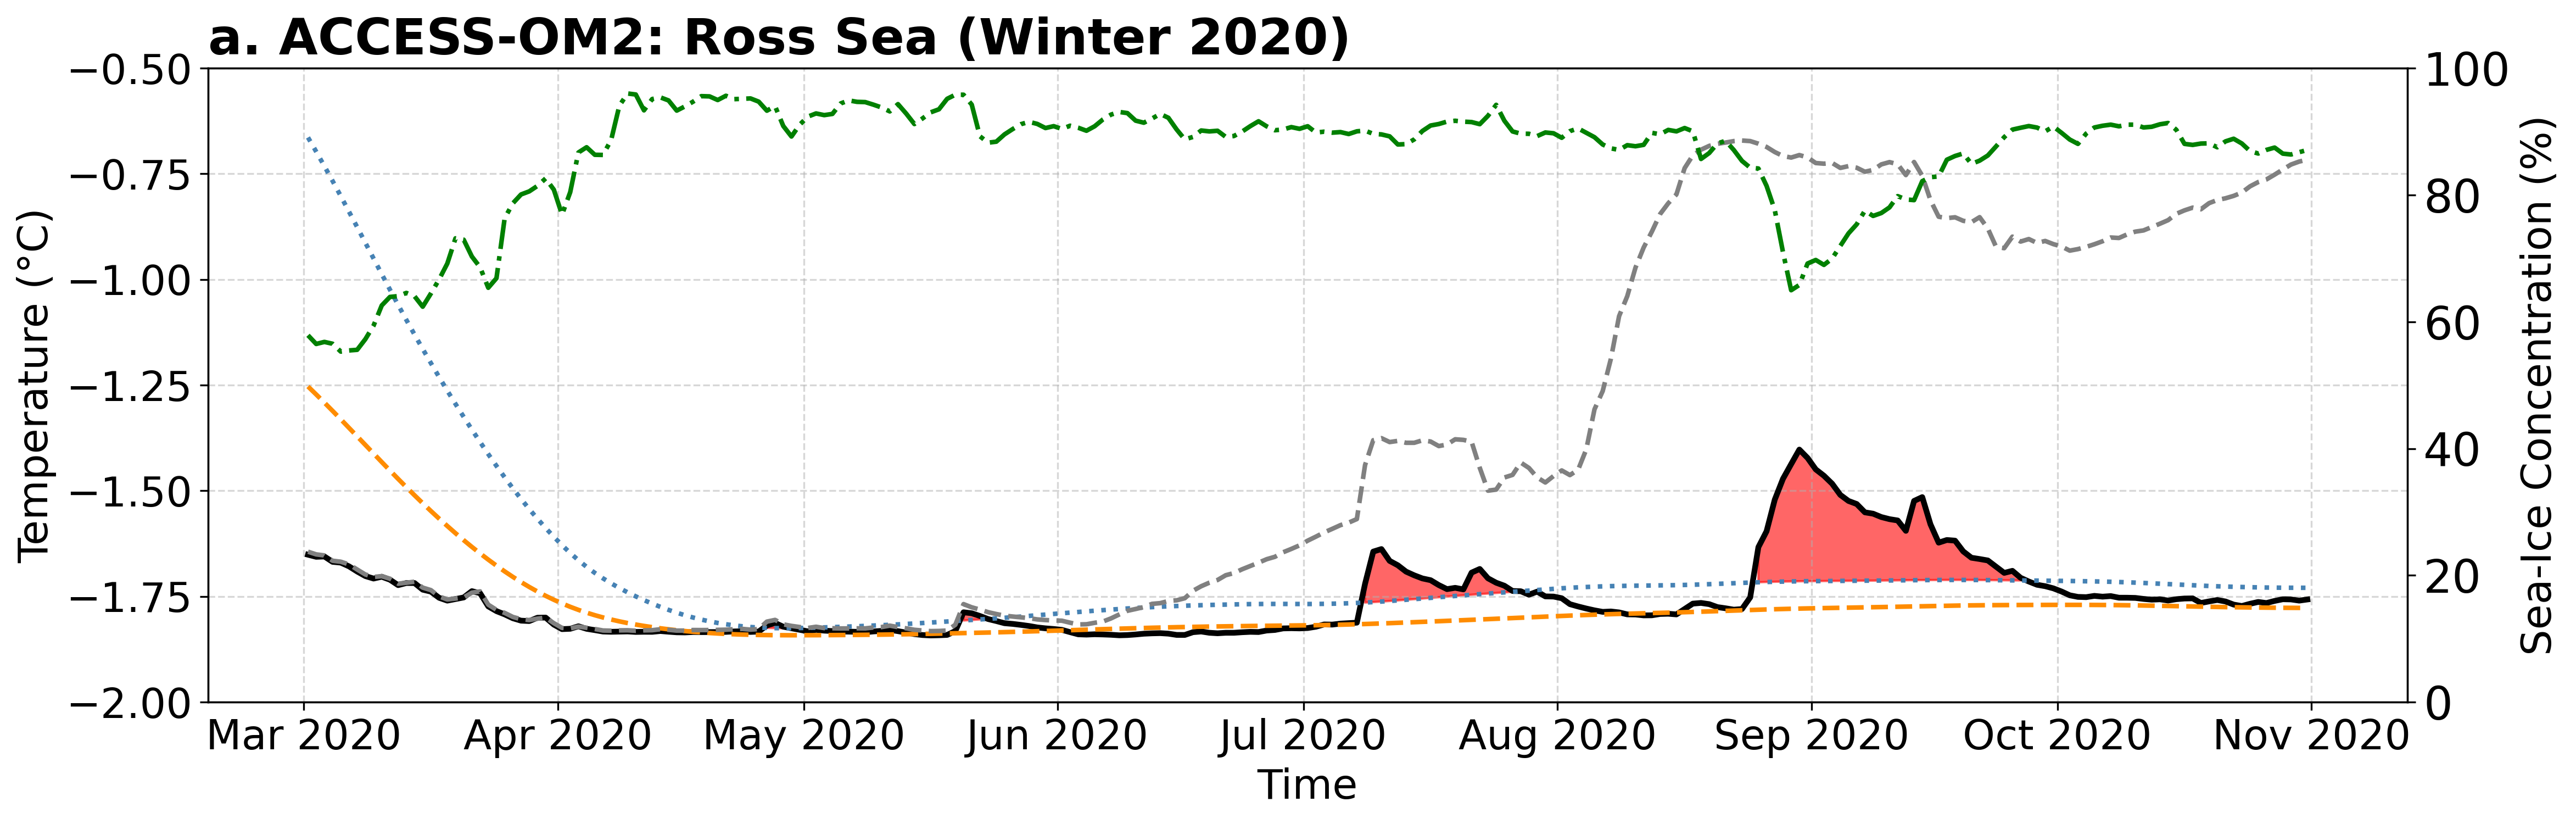

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# -----------------------------
# Global styling
# -----------------------------
# Set global matplotlib style to match Reynolds plot style
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 24,
    'axes.labelsize': 18,
    'axes.titlesize': 22,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
})
labelsize = 20

# -----------------------------
# Figure
# -----------------------------
fig, ax = plt.subplots(figsize=(16, 6))

# -----------------------------
# ACCESS-OM2 Time Series
# -----------------------------
time = temp_point['time'].values
sst_vals = temp_point.values
thresh_vals = thresh.values
seas_vals = seasonal.values
ml_temp_vals = ml_temp_point
ice_vals = ice_point.values
ice_vals_masked = np.where(ice_vals < 0.15, np.nan, ice_vals)

# Plot SST, threshold, climatology, ML Temp
ax.plot(time, sst_vals, color='black', linewidth=2.5, label='SST')
ax.plot(time, thresh_vals, color='steelblue', linestyle=':', linewidth=2, label='90th Percentile')
ax.plot(time, seas_vals, color='darkorange', linestyle='--', linewidth=2, label='Climatology')
ax.plot(time, ml_temp_vals, color='gray', linestyle='--', linewidth=2, label='ML Temp')

# Shade Marine Heatwaves
ax.fill_between(time, sst_vals, thresh_vals,
                where=(sst_vals > thresh_vals), color='red', alpha=0.6, label='MHW')

# Secondary y-axis: Sea-Ice
ax_sec = ax.twinx()
ax_sec.plot(time, ice_vals_masked, color='green', linewidth=2, linestyle='-.', label='Sea-Ice Concentration')

# -----------------------------
# Styling
# -----------------------------
ax.set_title("a. ACCESS-OM2: Ross Sea (Winter 2020)", loc='left', fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_ylim(-2, -0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params()
ax.grid(True, linestyle='--', alpha=0.5)

# Sea-Ice axis
ax_sec.set_ylabel('Sea-Ice Concentration (%)')
ax_sec.set_ylim(0, 1.0)
ax_sec.set_yticks(np.arange(0, 1.01, 0.2))
ax_sec.set_yticklabels([f'{int(t*100)}' for t in np.arange(0, 1.01, 0.2)])
ax_sec.tick_params(labelsize=labelsize)

# -----------------------------
# Legend
# -----------------------------
import matplotlib.lines as mlines
lines = [
    mlines.Line2D([], [], color='black', linewidth=2.5, label='SST'),
    mlines.Line2D([], [], color='steelblue', linewidth=2.5, linestyle=':', label='90th Percentile'),
    mlines.Line2D([], [], color='darkorange', linewidth=2.5, linestyle='--', label='Climatology'),
    mlines.Line2D([], [], color='gray', linewidth=2.5, linestyle='--', label='ML Temp'),
    mlines.Line2D([], [], color='green', linewidth=2.5, linestyle='-.', label='Sea-Ice Concentration'),
    mlines.Line2D([], [], color='red', linewidth=6, alpha=0.6, label='MHW')
]

fig.subplots_adjust(bottom=0.2)
# fig.legend(lines, [l.get_label() for l in lines], loc='lower center',
#            bbox_to_anchor=(0.5, -.04), ncol=3, frameon=False, fontsize=labelsize, handlelength=2)

fig.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/temperature_anomaly.png', dpi = 600)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()


## Import NOAA Data

### Sea Ice

In [25]:
import glob
import xarray as xr
import re

import xarray as xr

import xarray as xr

# Open only 2000–2023 files
sea_ice = xr.open_mfdataset(
    [
        f'/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/icec.day.mean.{year}.nc'
        for year in range(1982, 2024)
    ],
    combine='by_coords',
        chunks={'time': 365}  # chunk by year to reduce memory usage
)

# Select Antarctic region (latitudes south of -55)
sea_ice = sea_ice.sel(lat=slice(-90, -55))


In [26]:
ice_clim = xr.open_dataset('/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/ice_clim.nc')
ice_clim

<xarray.Dataset> Size: 295MB
Dimensions:    (lat: 140, lon: 1440, dayofyear: 366)
Coordinates:
  * lat        (lat) float32 560B -89.88 -89.62 -89.38 ... -55.62 -55.38 -55.12
  * lon        (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    icec       (lat, lon, dayofyear) float32 295MB ...

In [27]:
# Assign dayofyear to c_ice
c_ice = sea_ice.assign_coords(dayofyear=sea_ice['time'].dt.dayofyear)

# Align climatology using dayofyear and assign dates from temp
climatology_ice = ice_clim.sel(dayofyear=c_ice['dayofyear'])
climatology_ice = climatology_ice.icec.assign_coords(time=c_ice['time'])


### SSTA

In [28]:
import glob
import xarray as xr
import re

# Get a list of all NetCDF files
filelist = glob.glob('/g/data/e14/asg561/MHW_xarray/mhw_data_90pc/mhw*.nc')

# Define a regex pattern to match latitudes -90to-70 or -70to-50
pattern = re.compile(r'\.(-90to-70|-70to-50)\.')

# Filter the file list based on the pattern
filtered_files = [f for f in filelist if pattern.search(f)]

# Check if there are matching files
if filtered_files:
    # Open only the filtered files
    satellite_data = xr.open_mfdataset(filtered_files, combine='by_coords')
    print(satellite_data)
else:
    print("No matching files found!")

satellite_data

<xarray.Dataset> Size: 59GB
Dimensions:         (time: 15688, lat: 160, lon: 1440, time366: 366)
Coordinates:
  * lat             (lat) float32 640B -89.88 -89.62 -89.38 ... -50.38 -50.12
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time            (time) datetime64[ns] 126kB 1981-12-30 ... 2024-12-11
  * time366         (time366) datetime64[ns] 3kB 1983-12-30 ... 1984-12-29
Data variables:
    severity        (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    severity_index  (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ssta            (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    sst             (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology90   (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology     (time366, lat, lon) float32 337MB d

<xarray.Dataset> Size: 59GB
Dimensions:         (time: 15688, lat: 160, lon: 1440, time366: 366)
Coordinates:
  * lat             (lat) float32 640B -89.88 -89.62 -89.38 ... -50.38 -50.12
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time            (time) datetime64[ns] 126kB 1981-12-30 ... 2024-12-11
  * time366         (time366) datetime64[ns] 3kB 1983-12-30 ... 1984-12-29
Data variables:
    severity        (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    severity_index  (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ssta            (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    sst             (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology90   (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology     (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
Attributes:
    history:  Created in regional_MHW_hdd4_anomaly.py pctile=902025-01-06 14:...

In [29]:
# --- SST ---
time = slice('2020-03-01', '2020-10-31')
#lon = slice(360-148, 360-135)
lon = slice(360-190, 360-185)
lat = slice(-72, -68)

# --- SST ---
sst = satellite_data.sst.sel(lat=lat, lon=lon)
sst = sst.sel(time=time)
sst = sst.mean(dim=['lat', 'lon'])


# # --- SSTa ---
# ssta = satellite_data.ssta#.sel(lat=lat, lon=lon)
# sst = sst.mean(dim=['lat', 'lon'])
# ssta = sst.sel(time=time)

# --- Sea Ice Concentration and Climatology ---
c_ice = sea_ice.icec.sel(lon=lon, lat = lat)
c_ice = c_ice.sel(time=time).mean(dim=['lat', 'lon'])

# clim_ice = climatology_ice.sel(lon=lon)
# clim_ice = clim_ice.where(
#     (clim_ice.lat >= -70) & (clim_ice.lat <= -63),
#     drop=True
# )
# clim_ice = clim_ice.sel(time=time).mean(dim=['lat', 'lon'])

# --- Climatology 90 ---
clim = satellite_data.climatology90.sel(lat=lat, lon=lon)
clim = clim.mean(dim=['lat', 'lon'])

# --- Climatology ---
climate = satellite_data.climatology.sel(lat=lat, lon=lon)
climate = climate.mean(dim=['lat', 'lon'])

In [30]:
import numpy as np
import xarray as xr

# --- 1. Assign DOY (day-of-year) to `temp` ---
sst = sst.assign_coords(doy=sst['time'].dt.dayofyear)

# --- 2. Assign DOY 1–366 to the climatology datasets ---

# This assumes your climatology and climatology90 each have 366 entries
doy_full = np.arange(1, 367)

# Assign DOY as a coordinate
climatology = clim.assign_coords(doy=('time366', doy_full))
climatology90 = climate.assign_coords(doy=('time366', doy_full))
 
# Swap dimension so we can index by DOY instead of time366
climatology = climatology.swap_dims({'time366': 'doy'})
climatology90 = climatology90.swap_dims({'time366': 'doy'})

# --- 3. Align climatology with temp using DOY ---

# Select climatology using the DOY from temp, aligned over time
sst_clim = climatology.sel(doy=xr.DataArray(sst['doy'].values, dims='time'))
sst_clim = sst_clim.assign_coords(time=sst['time'])

# Repeat for threshold climatology
sst_clim90 = climatology90.sel(doy=xr.DataArray(sst['doy'].values, dims='time'))
sst_clim90 = sst_clim90.assign_coords(time=sst['time'])

sst_clim90.load()
sst_clim.load()
sst.load()
c_ice.load()

<xarray.DataArray 'icec' (time: 245)> Size: 980B
array([0.275     , 0.275     , 0.2775    , 0.275     , 0.275     ,
       0.24875   , 0.24499999, 0.24115382, 0.27846152, 0.2773077 ,
       0.2776923 , 0.29399997, 0.27850002, 0.262     , 0.2595    ,
       0.244     , 0.23649998, 0.23681818, 0.25      , 0.2675862 ,
       0.29918918, 0.3551282 , 0.36714286, 0.36677963, 0.3806349 ,
       0.41888887, 0.41192773, 0.47038093, 0.49062935, 0.50384104,
       0.5205031 , 0.5201169 , 0.53100526, 0.5805584 , 0.6269951 ,
       0.67013335, 0.7118677 , 0.7494795 , 0.7801464 , 0.7963736 ,
       0.81875455, 0.8212203 , 0.8487541 , 0.84933335, 0.87926984,
       0.90114284, 0.9034921 , 0.9073333 , 0.9139682 , 0.9213968 ,
       0.9314603 , 0.9374603 , 0.943619  , 0.95066667, 0.9577778 ,
       0.96311104, 0.96704763, 0.97073007, 0.9709841 , 0.97114277,
       0.9699046 , 0.9565397 , 0.9520634 , 0.9520635 , 0.9482222 ,
       0.94311106, 0.9461269 , 0.9507936 , 0.95514286, 0.9579365 ,
       0.96193653, 0.9670158 , 0.9682222 , 0.9682222 , 0.9603809 ,
       0.95412683, 0.9429206 , 0.93933326, 0.9379048 , 0.9382857 ,
       0.9412063 , 0.9505079 , 0.9521269 , 0.95285714, 0.9549841 ,
       0.9562222 , 0.9570159 , 0.957238  , 0.960127  , 0.9649206 ,
       0.96914274, 0.97238094, 0.97387296, 0.9734604 , 0.9750158 ,
       0.9764444 , 0.975873  , 0.9741905 , 0.9741587 , 0.9746348 ,
...
       0.9816825 , 0.98231745, 0.9830793 , 0.9836825 , 0.98406345,
       0.973619  , 0.97028565, 0.9700316 , 0.9699682 , 0.9702539 ,
       0.9731428 , 0.97549194, 0.9786983 , 0.979365  , 0.97939664,
       0.9796189 , 0.9813333 , 0.981873  , 0.98298407, 0.9843175 ,
       0.985873  , 0.986984  , 0.98879355, 0.99028563, 0.99111104,
       0.99073005, 0.9902539 , 0.9905713 , 0.99165076, 0.9910794 ,
       0.98850787, 0.98479354,        nan,        nan, 0.9482857 ,
       0.9568254 , 0.953492  , 0.94863486, 0.9517777 , 0.95441264,
       0.95714283, 0.96244437, 0.96406347, 0.96920633, 0.972     ,
       0.9747937 , 0.97669834, 0.976857  , 0.97723794, 0.97628564,
       0.9740951 , 0.97031736, 0.96841264, 0.9685396 , 0.96644443,
       0.96657145, 0.9698095 , 0.9724761 , 0.97622204, 0.98215866,
       0.98479354, 0.98603165, 0.98609513, 0.9856824 , 0.9842856 ,
       0.983492  , 0.9839363 , 0.98428565, 0.98447615, 0.9878094 ,
       0.9885395 , 0.98965067, 0.9906031 , 0.9906031 , 0.9896508 ,
       0.98952377, 0.98968244, 0.98993635, 0.99012685, 0.98806345,
       0.9864762 , 0.9870793 , 0.98866665, 0.9883173 , 0.9879999 ,
       0.9870793 , 0.98736507, 0.98615867, 0.9840317 , 0.98244435,
       0.9797459 , 0.9751428 , 0.97276187, 0.972857  , 0.97285706],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2020-03-01 2020-03-02 ... 2020-10-31

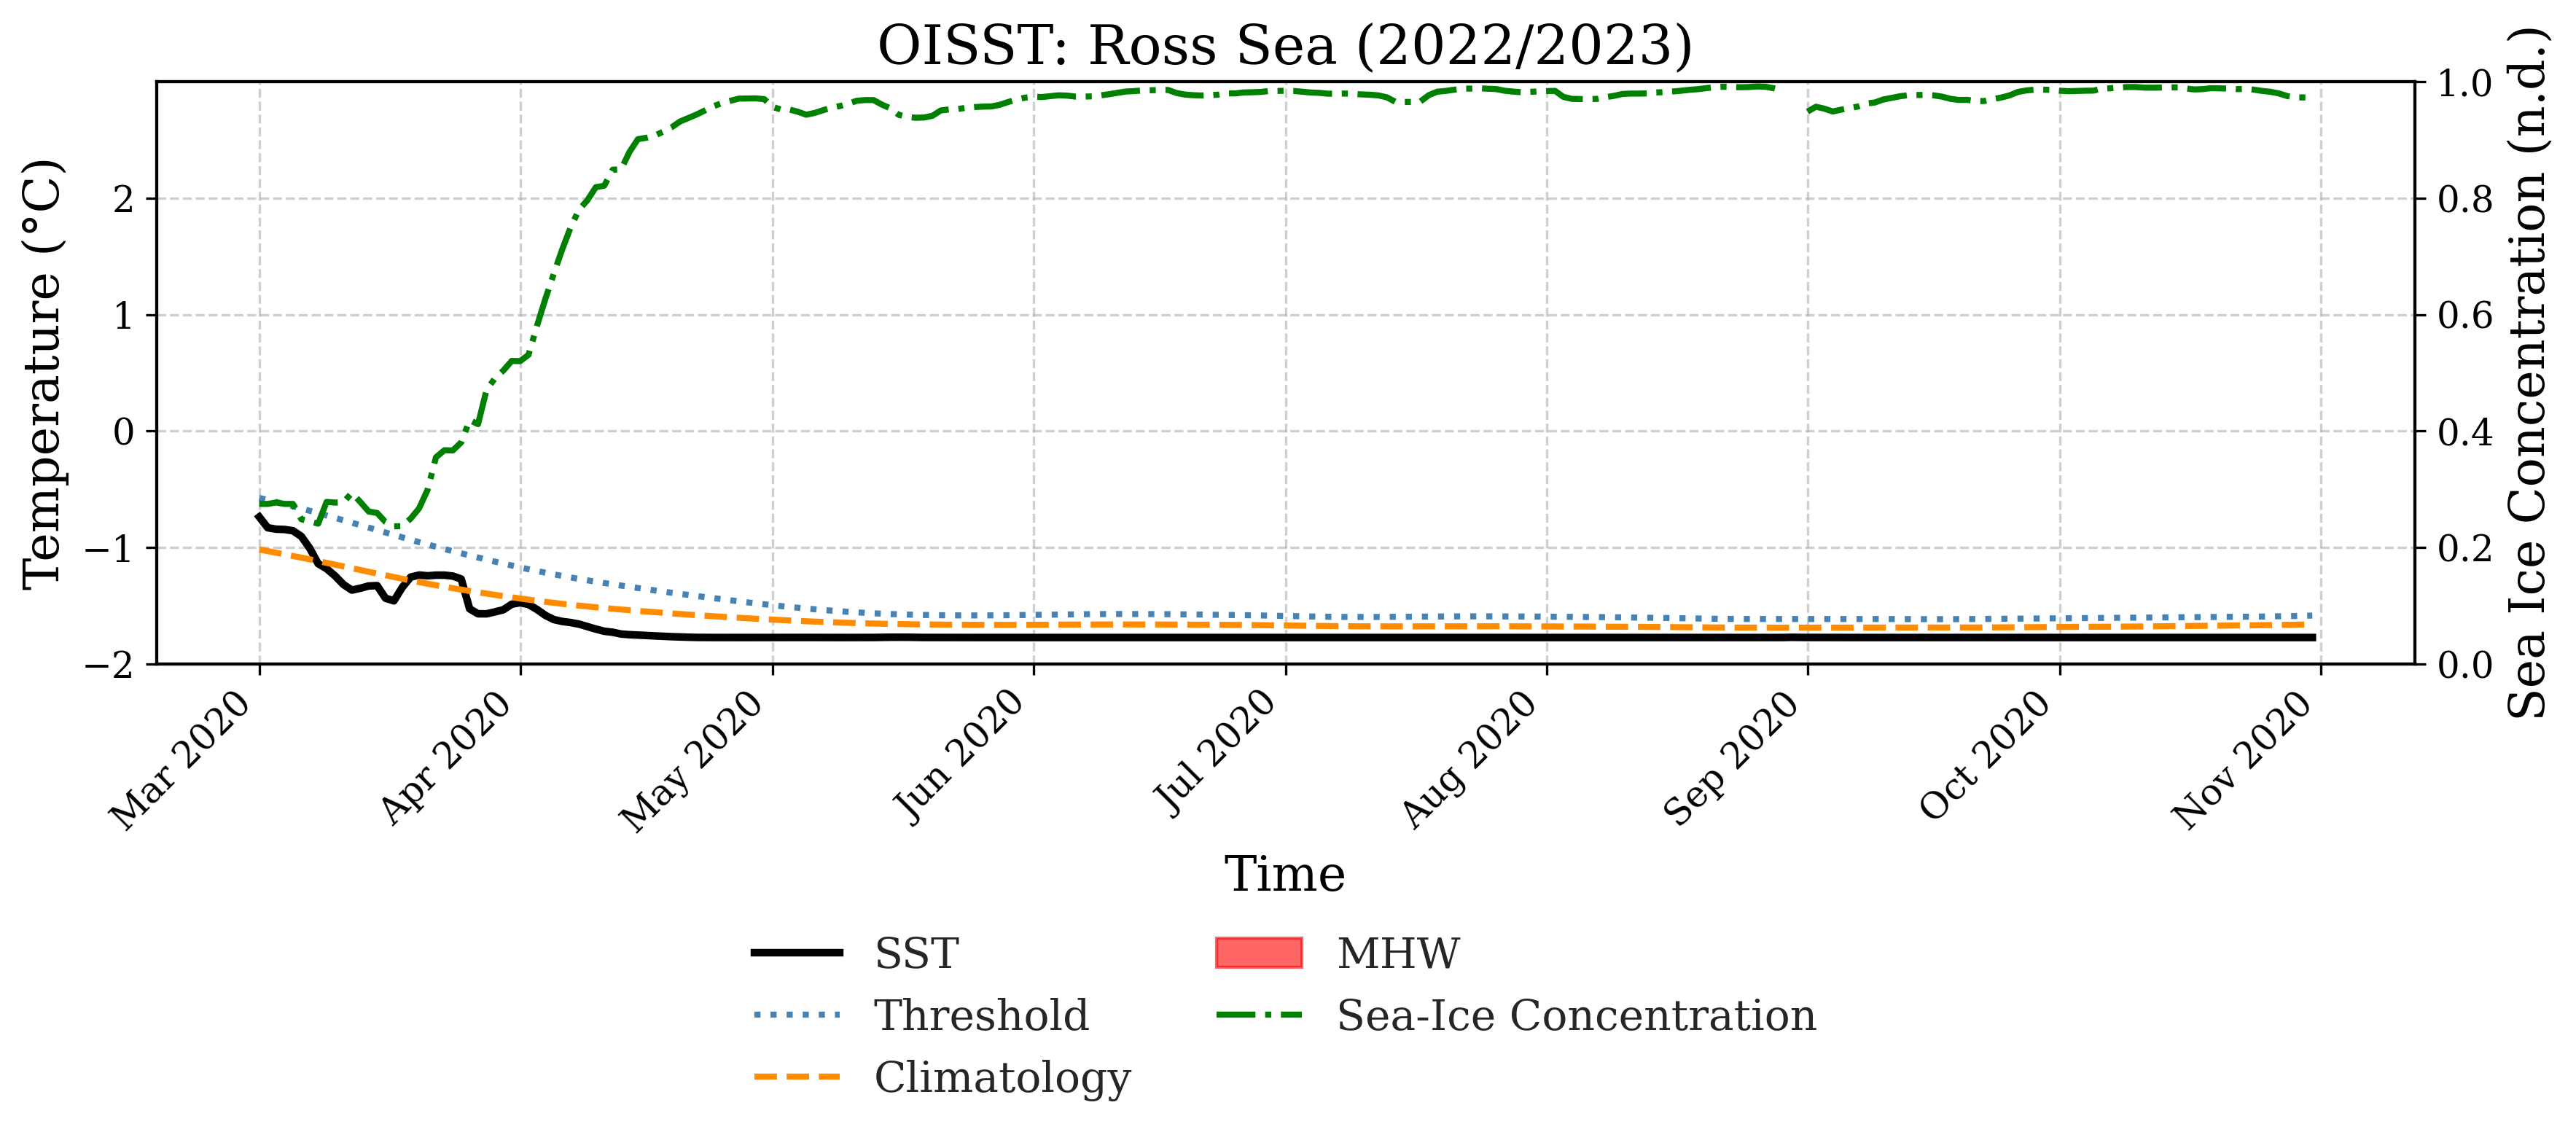

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

# Set global plot style
plt.rcParams.update({
    'font.family': 'DejaVu Serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

fig, ax1 = plt.subplots(figsize=(12, 6))

time = sst['time'].values
sst_vals = sst.values
thresh_vals = sst_clim.values
seas_vals = sst_clim90.values
ice_vals = c_ice.values
ice_time = c_ice['time']

# Mask sea ice values below 0.15 to NaN
ice_vals = np.where(ice_vals < 0.15, np.nan, ice_vals)

# Plot SST, Threshold, and Climatology on primary axis
ax1.plot(time, sst_vals, label='SST', linewidth=2.5, color='black')
ax1.plot(time, thresh_vals, label='Threshold', linestyle=':', linewidth=2, color='steelblue')
ax1.plot(time, seas_vals, label='Climatology', linestyle='--', linewidth=2, color='darkorange')

# Shade Marine Heatwave (SST > Threshold)
ax1.fill_between(time, sst_vals, thresh_vals,
                 where=(sst_vals > thresh_vals),
                 interpolate=True,
                 color='red', alpha=0.6, label='MHW')

# Secondary y-axis for Sea Ice Concentration
ax2 = ax1.twinx()
ax2.plot(ice_time, ice_vals, label='Sea-Ice Concentration', color='green', linewidth=2, linestyle='-.')
#ax2.axhline(y = 0.35, color='black', linewidth=2, linestyle='--', alpha = 0.5)

ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.01, 0.2))

# Labels and title
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Sea Ice Concentration (n.d.)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.set_title('OISST: Ross Sea (2022/2023)')

# Date formatting on x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
fig.autofmt_xdate(rotation=45)

# Black box around the plot
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.0)
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.0)

# Grid on primary axis only
ax1.set_ylim(-2, 3.0)                 
ax1.set_yticks(np.arange(-2, 3, 1))  

ax1.grid(True, linestyle='--', alpha=0.6)

# Combine legends below the plot
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

all_lines = lines_1 + lines_2
all_labels = labels_1 + labels_2

legend = ax1.legend(all_lines, all_labels,
                    loc='upper center',
                    bbox_to_anchor=(0.5, -0.4),
                    frameon=False,
                    ncol=2)

for text in legend.get_texts():
    text.set_alpha(0.85)
    text.set_color('black')

plt.tight_layout()
# plt.savefig(
#     "/g/data/e14/ts7341/Images_For_Manuscript/Ross_Sea/Observed_Marine_Heatwave.png",
#     dpi=300,
#     bbox_inches='tight'  # ensures nothing is cut off
# )
plt.show()

### Panels – NOAA

time
time
time


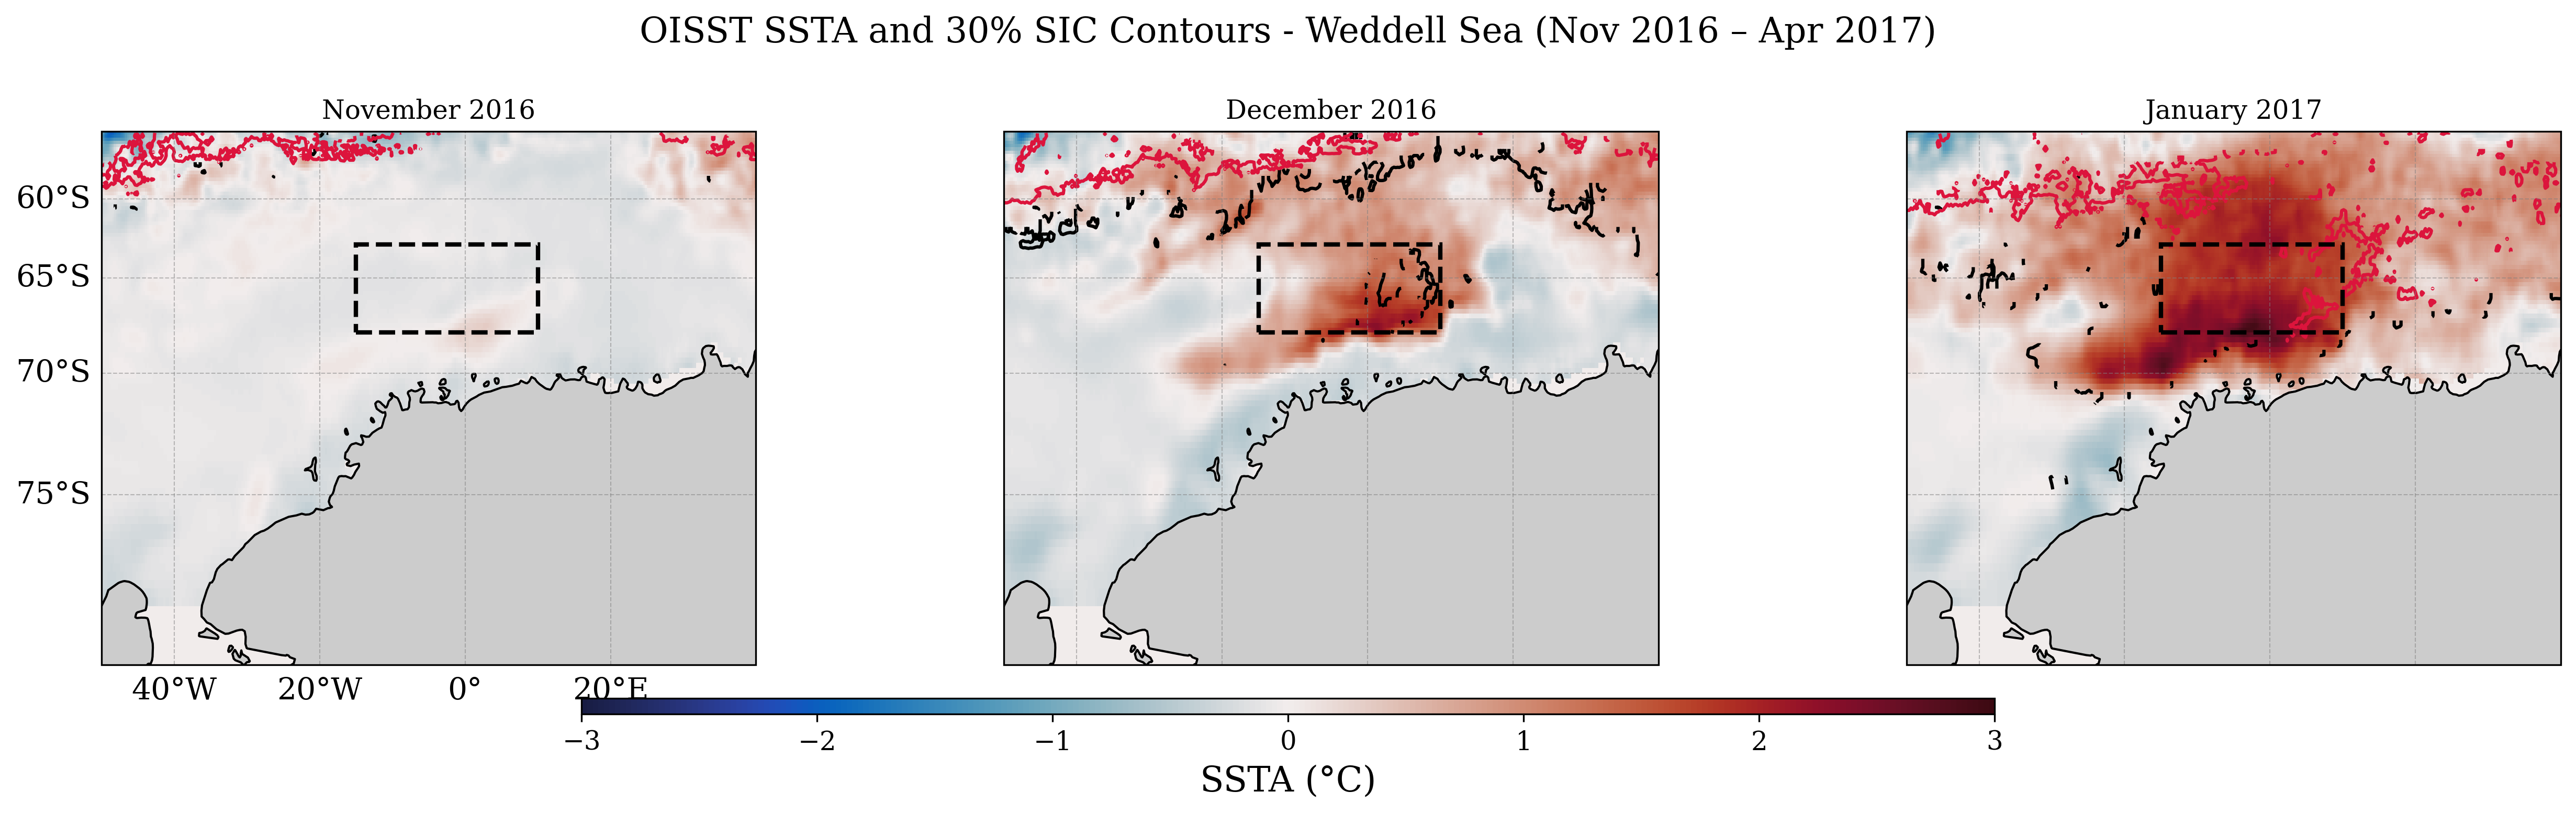

CPU times: user 29.7 s, sys: 3.91 s, total: 33.6 s
Wall time: 31.2 s


In [32]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.patches as mpatches
import cmocean.cm as cm
import pandas as pd
import calendar

# Set serif font globally
plt.rcParams["font.family"] = "serif"

# Month range
months = pd.date_range("2016-11-01", "2017-01-01", freq="MS")
n_months = len(months)

# Layout: 3 columns
ncols = 3
nrows = (n_months + ncols - 1) // ncols  # ceiling division for rows

# Create subplots
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(18, nrows * 5),  # wider figure for 3 across
    subplot_kw={"projection": ccrs.Mercator()}
)
axes = axes.flatten()

# Common parameters
extent = [-50, 40, -80, -55]
levels = [0.2]

for i, month_start in enumerate(months):
    month_end = month_start + pd.offsets.MonthEnd(1)
    time_slice = slice(str(month_start.date()), str(month_end.date()))
    month_name = calendar.month_name[month_start.month]
    year = month_start.year
    ax = axes[i]

    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add land features
    land = cft.NaturalEarthFeature("physical", "land", "50m",
                                   edgecolor="black", facecolor="0.8", linewidth=0.5)
    ax.add_feature(land)
    ax.coastlines(resolution="50m")

    # Extract and average data
    so_data = satellite_data.sel(lat=slice(-90, -50), lon=slice(0, 360)).sel(time=time_slice).mean("time")
    ssta = so_data.ssta.assign_coords(geolat_t=so_data.lat, geolon_t=so_data.lon)

    # Plot SSTA
    im = ssta.plot(
        x="geolon_t", y="geolat_t",
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-3, vmax=3,
        cmap=cm.balance,
        extend="both",
        add_colorbar=False
    )

    # Sea ice 30% contour
    ice_avg = sea_ice.icec.sel(time=time_slice).mean("time")
    ice_avg.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors="black",
        linewidths=1.5,
        add_colorbar=False
    )

    clim_ice_avg = climatology_ice.sel(time=time_slice).mean("time")
    clim_ice_avg.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors="crimson",
        linewidths=1.5,
        add_colorbar=False
    )

    # Study area box: lon -15 to 10, lat -68 to -63
    box = mpatches.Rectangle(
        (-15, -68), 25, 5,
        linewidth=2, edgecolor='black', linestyle='--',
        facecolor='none', transform=ccrs.PlateCarree(), zorder=5
    )
    ax.add_patch(box)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    
    # Only show labels on the first column of each row
    if i % ncols == 0:
        gl.left_labels = True
        gl.bottom_labels = True
    else:
        gl.left_labels = False
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False

    # Title
    ax.set_title(f"{month_name} {year}", fontsize=12)
    print('time')

# Hide extra subplot if 8 were created for 7 months
if len(axes) > n_months:
    for ax in axes[n_months:]:
        ax.set_visible(False)

# Shared colorbar
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label="SSTA (°C)")

# Super title
plt.suptitle("OISST SSTA and 30% SIC Contours - Weddell Sea (Nov 2016 – Apr 2017)",
             fontsize=16, y=0.97)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

### Panels for ACCESS-OM2 MHW

In [33]:
access_clim_aice = access_clim.aice

In [34]:
access_aice = ice.aice

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean.cm as cm
import matplotlib.patches as mpatches
import pandas as pd
import calendar

%matplotlib inline

# Set global serif font
plt.rcParams['font.family'] = 'serif'

# Define months range
months = pd.date_range('2016-11-01', '2017-04-01', freq='MS')
n_months = len(months)

# Layout: 3 columns
ncols = 3
nrows = (n_months + ncols - 1) // ncols  # ceiling division for rows

# Create subplots
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(18, nrows * 5),  # wider figure for 3 across
    subplot_kw={"projection": ccrs.Mercator()}
)
axes = axes.flatten()

# Common parameters
extent = [-50, 40, -80, -55]
levels = [0.2]

for i, month_start in enumerate(months):
    month_end = month_start + pd.offsets.MonthEnd(1)
    time_slice = slice(str(month_start.date()), str(month_end.date()))
    month_name = calendar.month_name[month_start.month]
    year = month_start.year
    ax = axes[i]

    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Land and coastlines
    land_50m = cft.NaturalEarthFeature("physical", "land", "50m",
                                       edgecolor="black", facecolor="0.8", linewidth=0.5)
    ax.add_feature(land_50m)
    ax.coastlines(resolution="50m")

    # SSTa
    ssta = SSTa.sst.sel(time=time_slice).mean('time')
    ssta_plot = ssta.plot(
        x="lon", y="lat", ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-3, vmax=3,
        cmap=cm.balance,
        extend="both",
        add_colorbar=False
    )

    # Sea ice contours
    ice_mean = access_aice.sel(time=time_slice).mean('time')
    clim_mean = access_clim_aice.sel(time=time_slice).mean('time')

    ice_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(),
                          levels=levels, colors='black', linewidths=1.5, add_colorbar=False)
    clim_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(),
                           levels=levels, colors='orange', linewidths=1.5, add_colorbar=False)

    # Study area box
    box = mpatches.Rectangle((-15, -68), 25, 5,
                             linewidth=2, edgecolor='black', linestyle='--',
                             facecolor='none', transform=ccrs.PlateCarree(), zorder=5)
    ax.add_patch(box)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    
    # Only show labels on the first column of each row
    if i % ncols == 0:
        gl.left_labels = True
        gl.bottom_labels = True
    else:
        gl.left_labels = False
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False


    # Title
    ax.set_title(f"{month_name} {year}", fontsize=12)

# Hide unused axes if fewer months than panels
for ax in axes[n_months:]:
    ax.set_visible(False)

# Shared colorbar
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
fig.colorbar(ssta_plot, cax=cbar_ax, orientation='horizontal', label='SSTA (°C)')

# Super title
plt.suptitle("ACCESS-OM2 SSTA and 30% SIC Contours - Weddell Sea (Nov 2020 – Apr 2021)",
             fontsize=16, y=0.97)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


## Combined Plotting

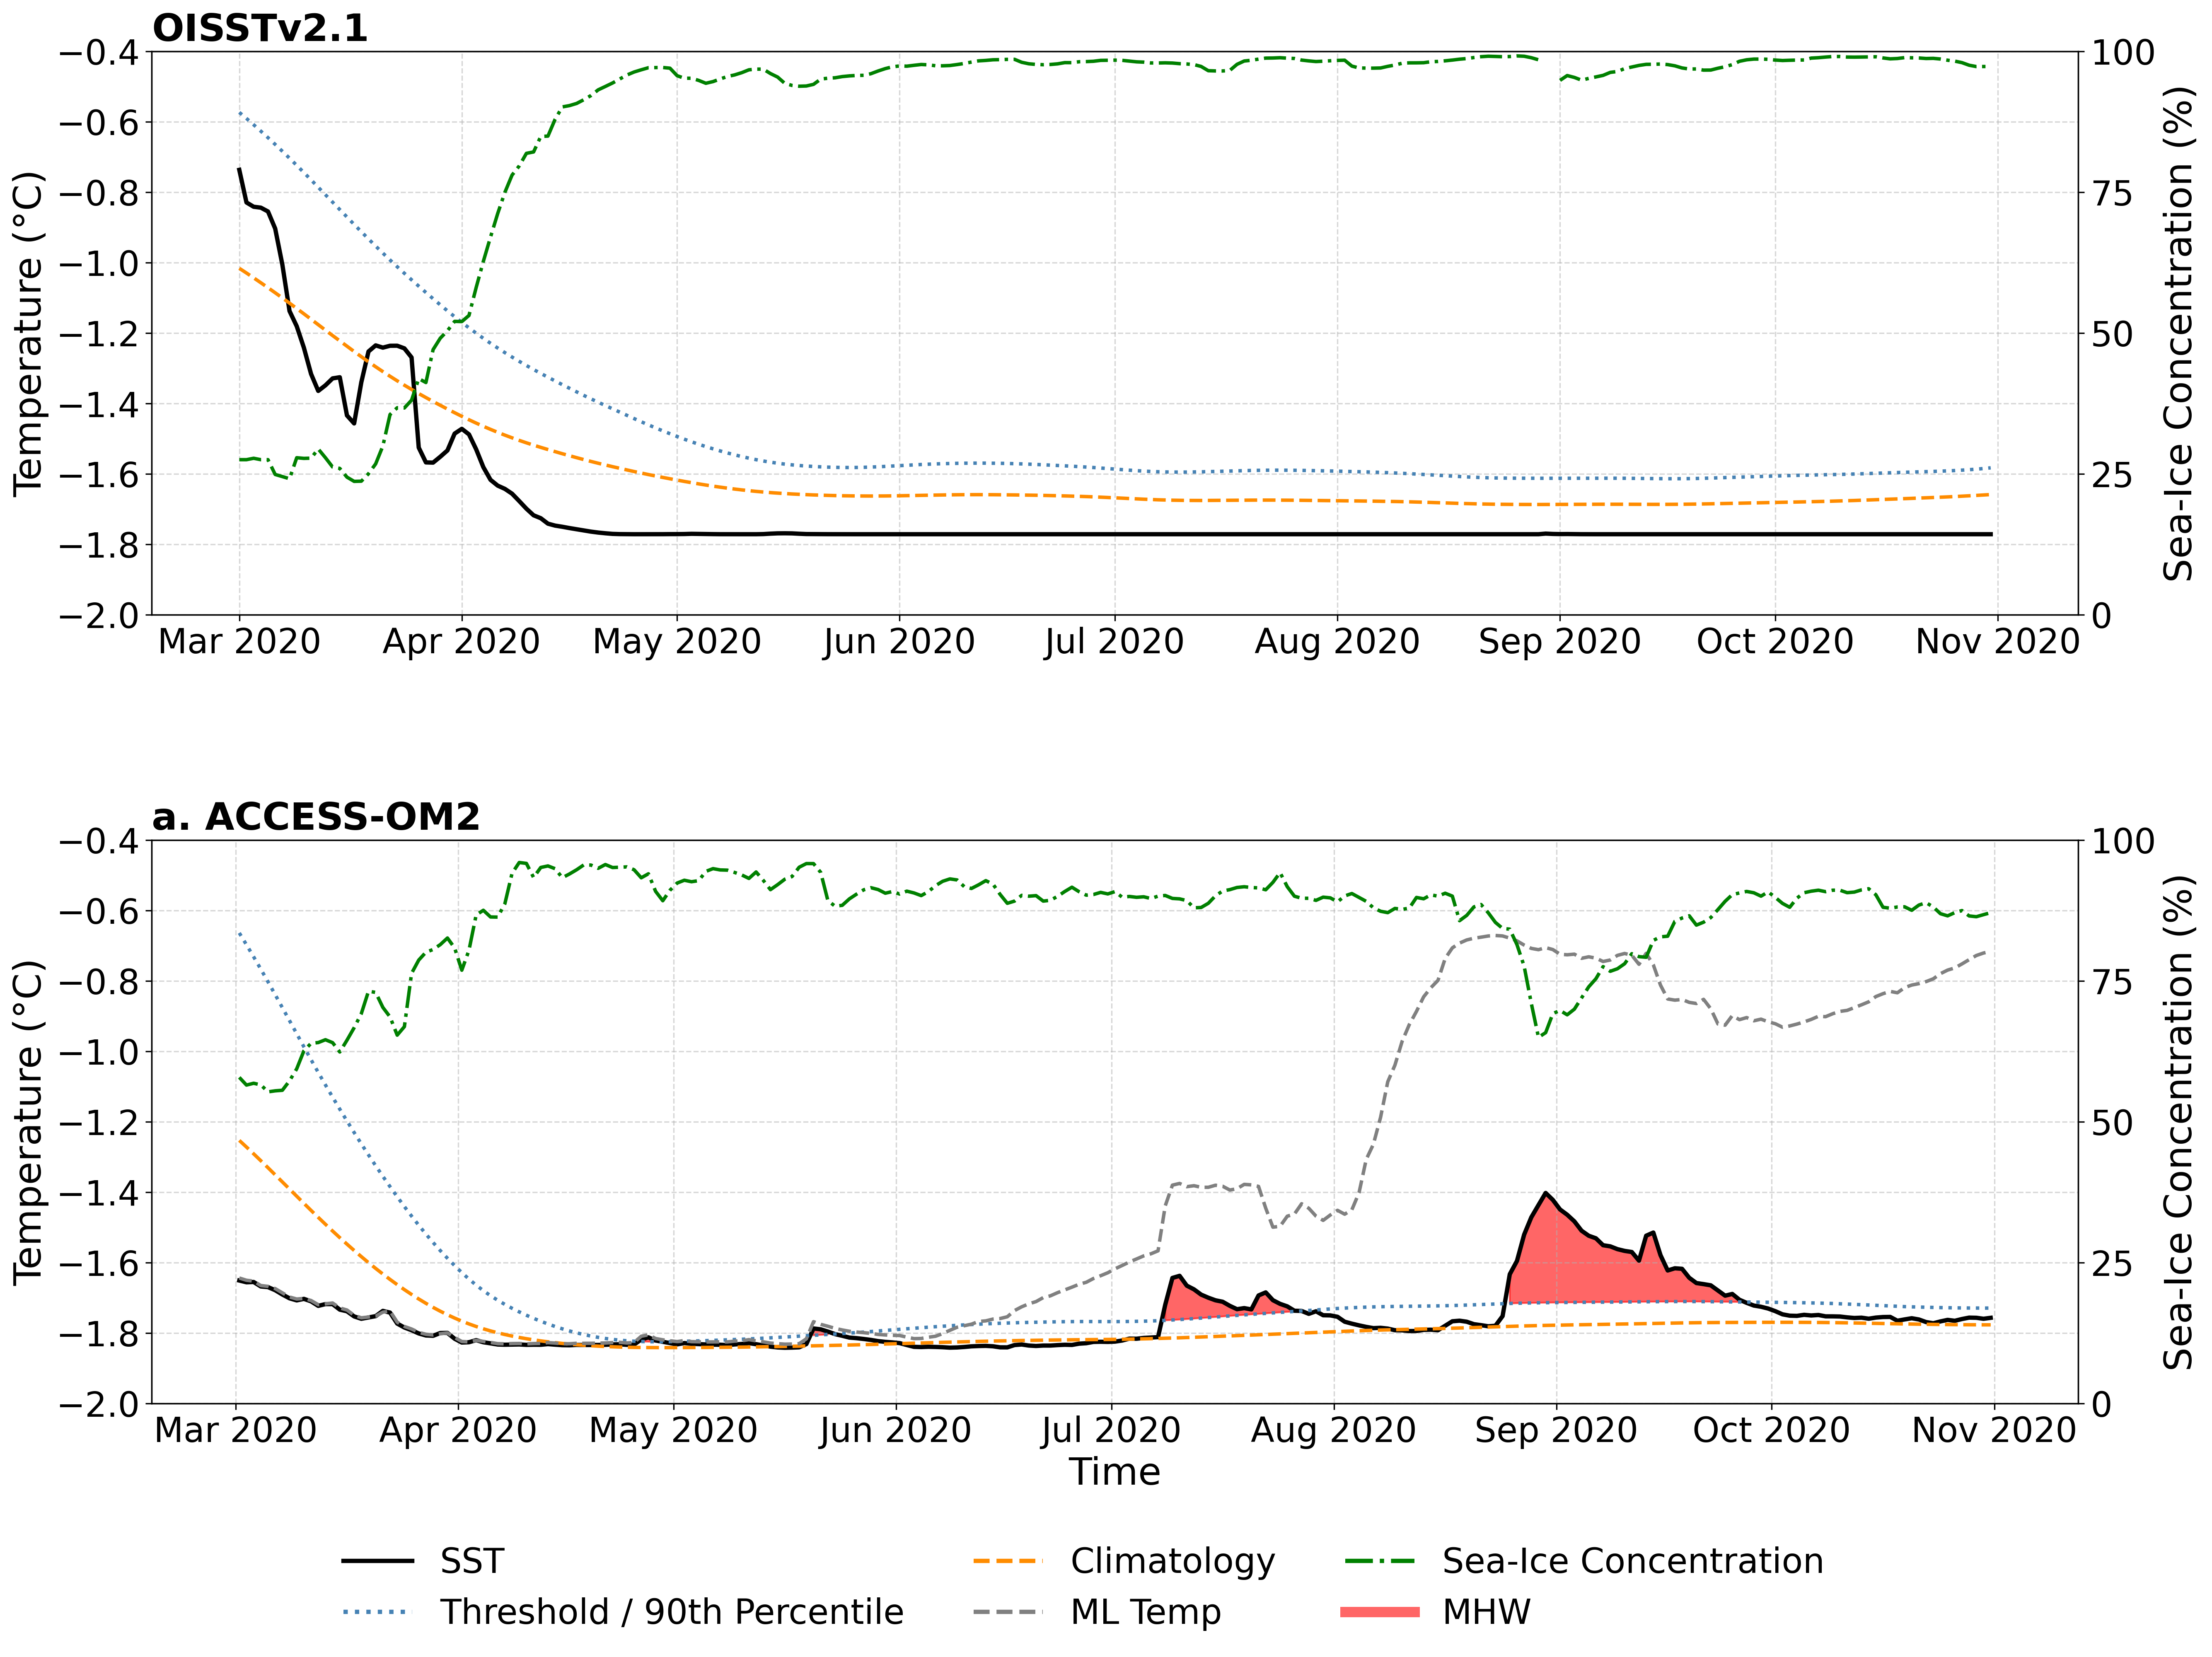

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# Global styling
# -----------------------------
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Arial-like
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'legend.fontsize': 18,
    'figure.dpi': 300,
})

labelsize = 20

# -----------------------------
# Figure
# -----------------------------
fig = plt.figure(figsize=(20, 16))
gs = plt.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4)

# -----------------------------
# Panel a: OISST Time Series
# -----------------------------
ax_a = fig.add_subplot(gs[0])
time_oisst = sst['time'].values
sst_vals_oisst = sst.values
thresh_vals_oisst = sst_clim.values
seas_vals_oisst = sst_clim90.values
ice_vals_oisst = c_ice.values
ice_vals_masked_oisst = np.where(ice_vals_oisst < 0.15, np.nan, ice_vals_oisst)

# Plot OISST
ax_a.plot(time_oisst, sst_vals_oisst, color='black', linewidth=2.5, label='SST')
ax_a.plot(time_oisst, thresh_vals_oisst, color='steelblue', linestyle=':', linewidth=2, label='Threshold')
ax_a.plot(time_oisst, seas_vals_oisst, color='darkorange', linestyle='--', linewidth=2, label='Climatology')
ax_a.fill_between(time_oisst, sst_vals_oisst, thresh_vals_oisst,
                  where=(sst_vals_oisst > thresh_vals_oisst), color='red', alpha=0.6, label='MHW')

# Secondary y-axis (sea-ice)
ax_a_sec = ax_a.twinx()
ax_a_sec.plot(time_oisst, ice_vals_masked_oisst, color='green', linewidth=2, linestyle='-.', label='Sea-Ice')

# Styling
ax_a.set_title("OISSTv2.1", loc='left', fontweight='bold')
ax_a.set_ylabel('Temperature (°C)')
ax_a.set_ylim(-2, -0.4)
ax_a.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_a.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_a.tick_params(labelsize=labelsize)
ax_a.grid(True, linestyle='--', alpha=0.5)

# Sea-ice axis as percentage
ax_a_sec.set_ylabel('Sea-Ice Concentration (%)')
ax_a_sec.set_ylim(0, 1.0)
ax_a_sec.set_yticks(np.arange(0, 1.01, 0.25))
ax_a_sec.set_yticklabels([f'{int(t*100)}' for t in np.arange(0, 1.01, 0.25)])
ax_a_sec.tick_params(labelsize=labelsize)

# -----------------------------
# Panel b: ACCESS Time Series
# -----------------------------
ax_b = fig.add_subplot(gs[1])
time_access = temp_point['time'].values
sst_vals_access = temp_point.values
thresh_vals_access = thresh.values
seas_vals_access = seasonal.values
ml_temp_vals = ml_temp_point
ice_vals_access = ice_point.values
ice_vals_masked_access = np.where(ice_vals_access < 0.15, np.nan, ice_vals_access)

# Plot ACCESS
ax_b.plot(time_access, sst_vals_access, color='black', linewidth=2.5, label='SST')
ax_b.plot(time_access, thresh_vals_access, color='steelblue', linestyle=':', linewidth=2, label='90th Percentile')
ax_b.plot(time_access, seas_vals_access, color='darkorange', linestyle='--', linewidth=2, label='Climatology')
ax_b.plot(time_access, ml_temp_vals, color='gray', linestyle='--', linewidth=2, label='ML Temp')
ax_b.fill_between(time_access, sst_vals_access, thresh_vals_access,
                  where=(sst_vals_access > thresh_vals_access), color='red', alpha=0.6, label='MHW')

# Secondary y-axis (sea-ice)
ax_b_sec = ax_b.twinx()
ax_b_sec.plot(time_access, ice_vals_masked_access, color='green', linewidth=2, linestyle='-.', label='Sea-Ice Concentration')

# Styling
ax_b.set_title("a. ACCESS-OM2", loc='left', fontweight='bold')
ax_b.set_xlabel('Time')
ax_b.set_ylabel('Temperature (°C)')
ax_b.set_ylim(-2, -0.4)
ax_b.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_b.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_b.tick_params(labelsize=labelsize)
ax_b.grid(True, linestyle='--', alpha=0.5)

# Sea-ice axis as percentage
ax_b_sec.set_ylabel('Sea-Ice Concentration (%)')
ax_b_sec.set_ylim(0, 1.0)
ax_b_sec.set_yticks(np.arange(0, 1.01, 0.25))
ax_b_sec.set_yticklabels([f'{int(t*100)}' for t in np.arange(0, 1.01, 0.25)])
ax_b_sec.tick_params(labelsize=labelsize)

# -----------------------------
# Legend below b.
# -----------------------------
import matplotlib.lines as mlines
lines = [
    mlines.Line2D([], [], color='black', linewidth=2.5, label='SST'),
    mlines.Line2D([], [], color='steelblue', linewidth=2.5, linestyle=':', label='Threshold / 90th Percentile'),
    mlines.Line2D([], [], color='darkorange', linewidth=2.5, linestyle='--', label='Climatology'),
    mlines.Line2D([], [], color='gray', linewidth=2.5, linestyle='--', label='ML Temp'),
    mlines.Line2D([], [], color='green', linewidth=2.5, linestyle='-.', label='Sea-Ice Concentration'),
    mlines.Line2D([], [], color='red', linewidth=6, alpha=0.6, label='MHW')
]

fig.subplots_adjust(bottom=0.2)
fig.legend(lines, [l.get_label() for l in lines], loc='lower center',
           bbox_to_anchor=(0.5, .07), ncol=3, frameon=False, fontsize=labelsize, handlelength=2)

plt.tight_layout(rect=[0, 0.08, 1, 1])

fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/temperature_anomaly.png", dpi=400, bbox_inches='tight')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.patches as mpatches
import cmocean.cm as cm
import pandas as pd
import calendar
import matplotlib.lines as mlines

# -----------------------------
# Parameters
# -----------------------------
months_oisst = pd.date_range("2016-11-01", "2017-01-01", freq="MS")
months_access = pd.date_range("2016-11-01", "2017-01-01", freq="MS")
extent = [-50, 40, -80, -55]
levels = [0.3]
box_coords = [-15, -68, 25, 5]  # study box [lon, lat, width, height]

# -----------------------------
# Font sizes
# -----------------------------
panel_title_size = 28  # month titles above each map
grid_label_size = 24   # cartopy gridline labels
colorbar_label_size = 28
legend_size = 28

# -----------------------------
# Create figure
# -----------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(28, 16),
    subplot_kw={'projection': ccrs.Mercator()}
)
axes = axes.flatten()

# -----------------------------
# Panel C: OISST
# -----------------------------
for i, month_start in enumerate(months_oisst):
    ax = axes[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature("physical", "land", "50m",
                                           edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    # OISST SSTA
    so_data = satellite_data.sel(lat=slice(-90, -50), lon=slice(0, 360)).sel(
        time=slice(str(month_start.date()), str((month_start + pd.offsets.MonthEnd(1)).date()))
    ).mean("time")
    ssta = so_data.ssta.assign_coords(geolat_t=so_data.lat, geolon_t=so_data.lon)
    im = ssta.plot(x="geolon_t", y="geolat_t", ax=ax, transform=ccrs.PlateCarree(),
                   vmin=-3, vmax=3, cmap=cm.balance, add_colorbar=False)

    # Sea-ice contours
    ice_avg = sea_ice.icec.sel(time=slice(str(month_start.date()),
                                          str((month_start + pd.offsets.MonthEnd(1)).date()))).mean("time")
    clim_avg = climatology_ice.sel(time=slice(str(month_start.date()),
                                              str((month_start + pd.offsets.MonthEnd(1)).date()))).mean("time")
    ice_avg.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                         colors='black', linewidths=2, add_colorbar=False)
    clim_avg.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                          colors='orange', linewidths=2, add_colorbar=False)

    # Study box
    ax.add_patch(mpatches.Rectangle(box_coords[:2], box_coords[2], box_coords[3],
                                    linewidth=2, edgecolor='black', linestyle='--',
                                    facecolor='none', transform=ccrs.PlateCarree(), zorder=5))

    # Month title
    month_name = calendar.month_abbr[month_start.month]
    ax.set_title(f"{month_name} – {month_start.year}", fontsize=32)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray',
                      alpha=0.5, linestyle='--')
    gl.left_labels = i % 3 == 0
    gl.bottom_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 32}
    gl.ylabel_style = {'size': 32}

# -----------------------------
# Panel D: ACCESS-OM2
# -----------------------------
for i, month_start in enumerate(months_access):
    ax = axes[i + 3]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature("physical", "land", "50m",
                                           edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    # ACCESS SSTA
    ssta = SSTa.sst.sel(time=slice(str(month_start.date()),
                                   str((month_start + pd.offsets.MonthEnd(1)).date()))).mean('time')
    im = ssta.plot(x="lon", y="lat", ax=ax, transform=ccrs.PlateCarree(),
                   vmin=-3, vmax=3, cmap=cm.balance, add_colorbar=False)

    # Sea-ice contours
    ice_mean = access_aice.sel(time=slice(str(month_start.date()),
                                          str((month_start + pd.offsets.MonthEnd(1)).date()))).mean('time')
    clim_mean = access_clim_aice.sel(time=slice(str(month_start.date()),
                                                str((month_start + pd.offsets.MonthEnd(1)).date()))).mean('time')
    ice_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                          colors='black', linewidths=2, add_colorbar=False)
    clim_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                           colors='orange', linewidths=2, add_colorbar=False)

    # Study box
    ax.add_patch(mpatches.Rectangle(box_coords[:2], box_coords[2], box_coords[3],
                                    linewidth=2, edgecolor='black', linestyle='--',
                                    facecolor='none', transform=ccrs.PlateCarree(), zorder=5))

    # Month title
    month_name = calendar.month_abbr[month_start.month]
    ax.set_title(f"{month_name} – {month_start.year}", fontsize=32)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray',
                      alpha=0.5, linestyle='--')
    gl.left_labels = i % 3 == 0
    gl.bottom_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 32}
    gl.ylabel_style = {'size': 32}

# -----------------------------
# Shared vertical colorbar
# -----------------------------
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('SSTA (°C)', fontsize=34)
cbar.ax.tick_params(labelsize=colorbar_label_size)

# -----------------------------
# Legend below panels
# -----------------------------
sst_line = mlines.Line2D([], [], color='black', linewidth=2, label='SST')
sic_line = mlines.Line2D([], [], color='black', linewidth=2, linestyle='-', label='Sea-Ice: 30% Contour')
clim_line = mlines.Line2D([], [], color='orange', linewidth=2, linestyle='-', label='Climatological Sea-Ice: 30% Contour')

fig.legend(handles=[sst_line, sic_line, clim_line],
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=3, frameon=False, fontsize=34)

plt.tight_layout(rect=[0, 0.05, 0.92, 1])
plt.show()
